In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

In [3]:
filelist=os.listdir("/home/seo/ISIC DATA")
meta=[file for file in filelist if not file.endswith(".jpeg") and not file.endswith(".png") and file.startswith("ISIC")]
pics=[file for file in filelist if (file.endswith(".jpeg") or file.endswith(".png")) and file.startswith("ISIC")]
masklist=os.listdir("/home/seo/Masks")
masks=[file for file in masklist if file.endswith(".png") and file.startswith("ISIC")]
masks

['ISIC_0012653_segmentation.png',
 'ISIC_0000116_segmentation.png',
 'ISIC_0014985_segmentation.png',
 'ISIC_0000098_segmentation.png',
 'ISIC_0010186_segmentation.png',
 'ISIC_0010344_segmentation.png',
 'ISIC_0000018_segmentation.png',
 'ISIC_0012324_segmentation.png',
 'ISIC_0010252_segmentation.png',
 'ISIC_0013120_segmentation.png',
 'ISIC_0000326_segmentation.png',
 'ISIC_0000409_segmentation.png',
 'ISIC_0010358_segmentation.png',
 'ISIC_0013031_segmentation.png',
 'ISIC_0012363_segmentation.png',
 'ISIC_0010191_segmentation.png',
 'ISIC_0010062_segmentation.png',
 'ISIC_0015200_segmentation.png',
 'ISIC_0000236_segmentation.png',
 'ISIC_0011292_segmentation.png',
 'ISIC_0011225_segmentation.png',
 'ISIC_0010093_segmentation.png',
 'ISIC_0000358_segmentation.png',
 'ISIC_0000137_segmentation.png',
 'ISIC_0010603_segmentation.png',
 'ISIC_0012988_segmentation.png',
 'ISIC_0014291_segmentation.png',
 'ISIC_0010844_segmentation.png',
 'ISIC_0015956_segmentation.png',
 'ISIC_0000161

In [4]:
mask2=[file.split('_segmentation')[0] for file in masklist if file.endswith(".png") and file.startswith("ISIC")]
test_pics=[file for file in pics if file.split('.jpeg')[0] in mask2]

In [5]:
ids=test_pics
print("No. of images = ", len(ids))

No. of images =  2186


In [6]:
test_pics[1].split('.')[0]

'ISIC_0012224'

In [7]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [ ]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
#for n, id_ in enumerate(ids):
    # Load images
    img = load_img("/home/seo/ISIC DATA/"+str(id_), grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("/home/seo/Masks/"+id_.split('.')[0]+'_segmentation.png', grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/home/seo/environments/my_env/lib/python3.6/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [9]:
#import pickle
#with open('X.pickle', 'wb') as f:
#    pickle.dump(X, f)
#with open('y.pickle', 'wb') as f:
#    pickle.dump(y, f)

In [8]:
import pickle

X=pickle.load(open('X.pickle',"rb"))
y=pickle.load(open('y.pickle',"rb"))

In [21]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [22]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [23]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [32]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 128, 128, 16) 64          conv2d_40[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 128, 128, 16) 0           batch_normalization_38[0][0]     
__________________________________________________________________________________________________
max_poolin

In [33]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [27]:
import pickle

model=pickle.load(open('model.pickle',"rb"))

In [34]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Train on 1967 samples, validate on 219 samples
Epoch 1/50
1967/1967 [==============================] - 165s 84ms/step - loss: 0.3907 - acc: 0.8372 - val_loss: 0.5053 - val_acc: 0.8372

Epoch 00001: val_loss improved from inf to 0.50528, saving model to model-tgs-salt.h5
Epoch 2/50
1967/1967 [==============================] - 156s 79ms/step - loss: 0.2518 - acc: 0.8867 - val_loss: 0.2127 - val_acc: 0.8884

Epoch 00002: val_loss improved from 0.50528 to 0.21273, saving model to model-tgs-salt.h5
Epoch 3/50
1967/1967 [==============================] - 157s 80ms/step - loss: 0.2134 - acc: 0.8919 - val_loss: 0.1934 - val_acc: 0.8979

Epoch 00003: val_loss improved from 0.21273 to 0.19344, saving model to model-tgs-salt.h5
Epoch 4/50
1967/1967 [==============================] - 156s 79ms/step - loss: 0.1909 - acc: 0.8960 - val_loss: 0.1980 - val_acc: 0.8926

Epoch 00004: val_loss did not improve from 0.19344
Epoch 5/50
1967/1967 [==============================] - 154s 78ms/step - loss: 0.182

In [35]:
with open('fit_model.pickle', 'wb') as f:
    pickle.dump(results, f)
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)

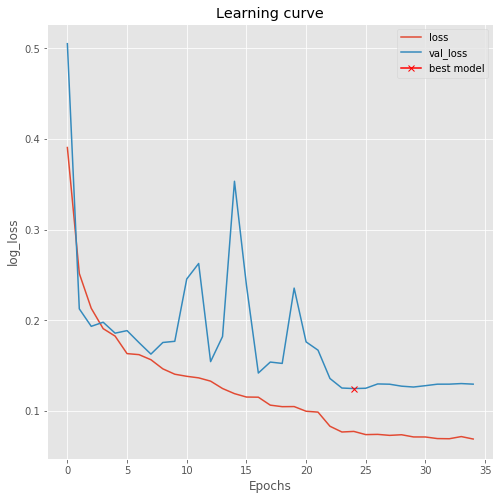

In [36]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
# Load best model
model.load_weights('model-tgs-salt.h5')

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

In [14]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

219/219 [==============================] - ETA: 16 - ETA: 13 - ETA: 10 - ETA: 7 - ETA:  - ETA:  - 19s 86ms/step


In [1]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('lesion Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('lesion Predicted binary');

In [2]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

NameError: name 'X_train' is not defined

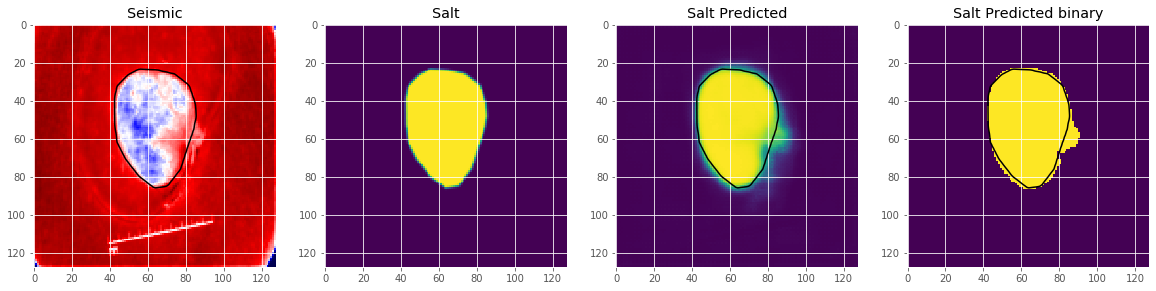

In [21]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

In [22]:
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)

In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 128, 128, 16) 0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
max_poolin